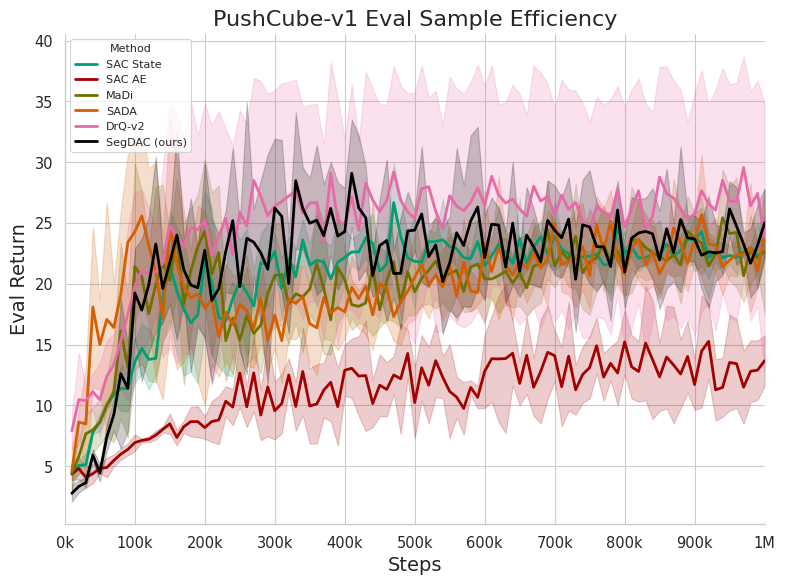

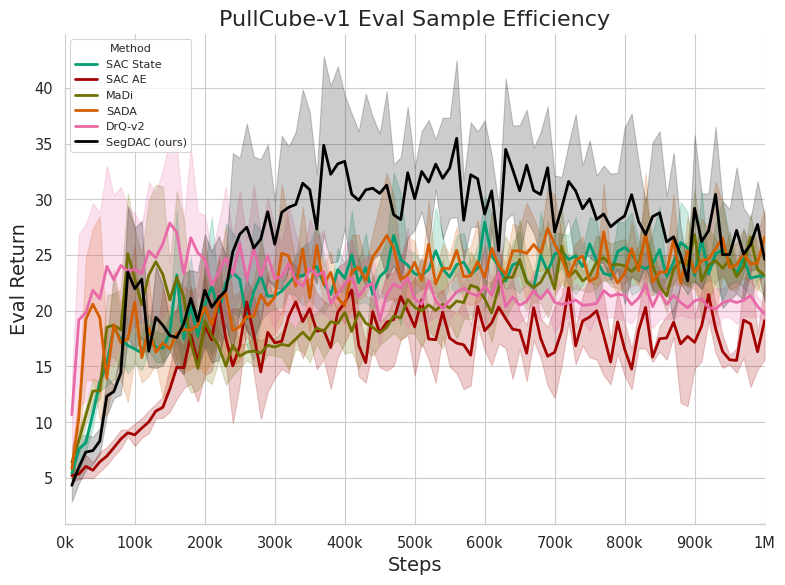

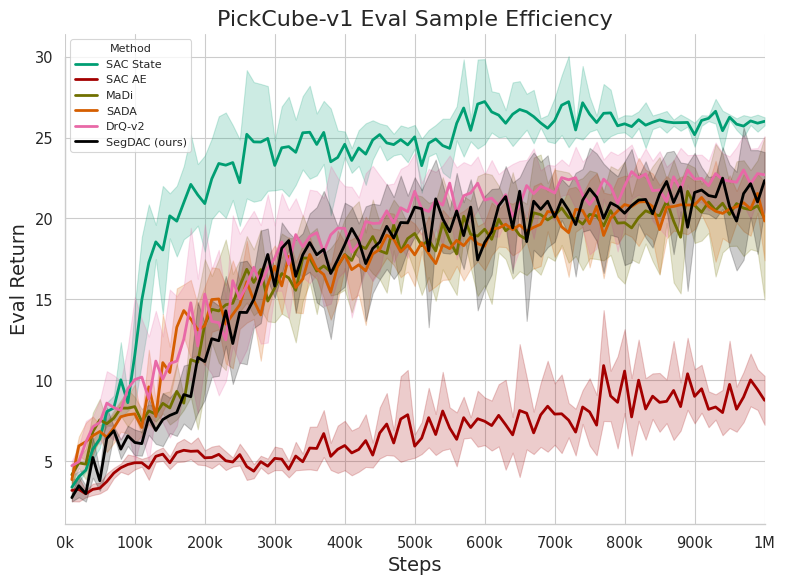

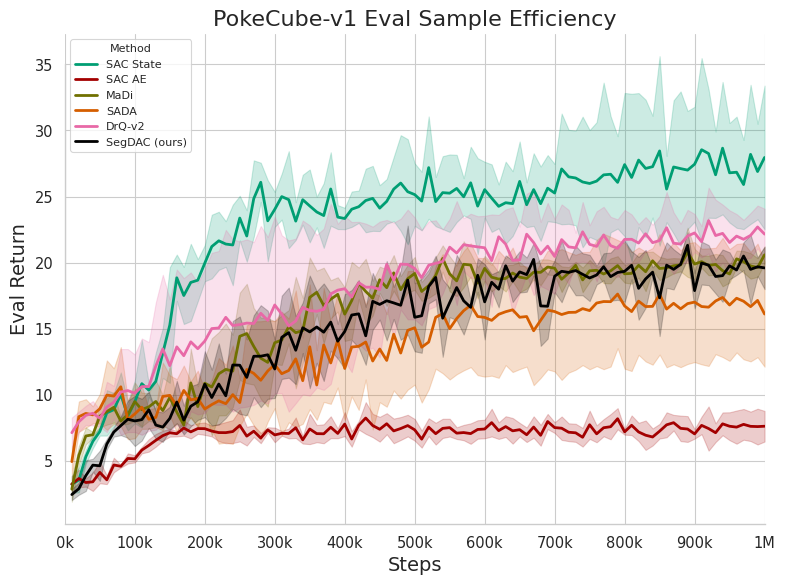

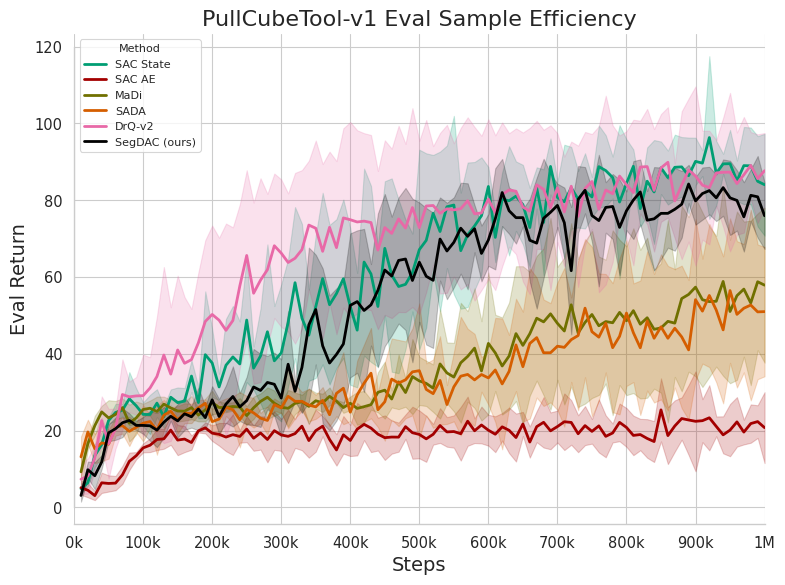

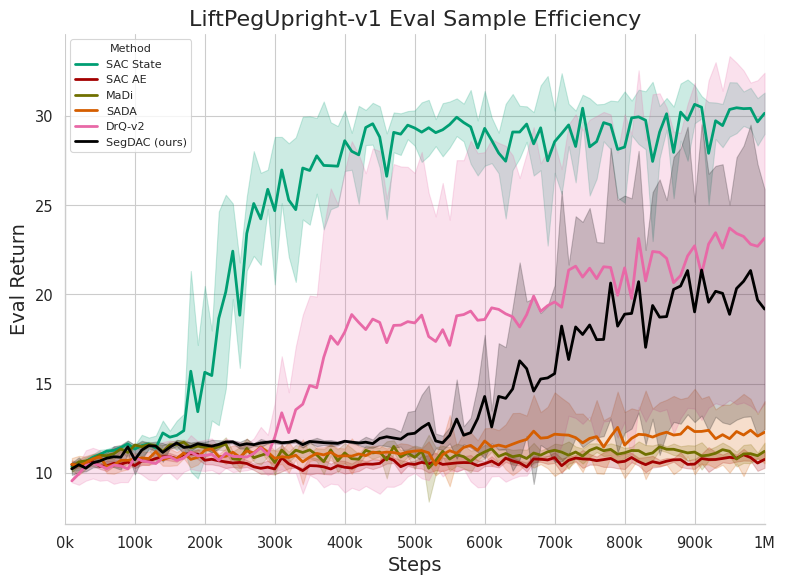

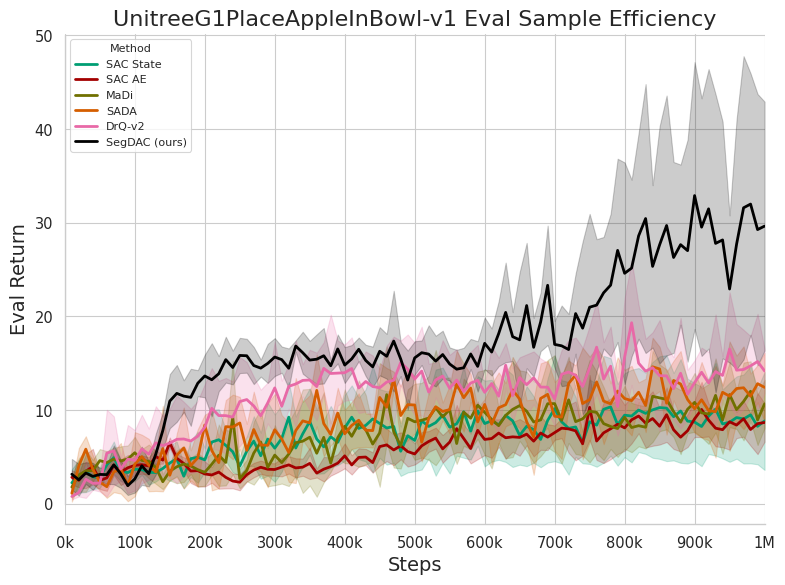

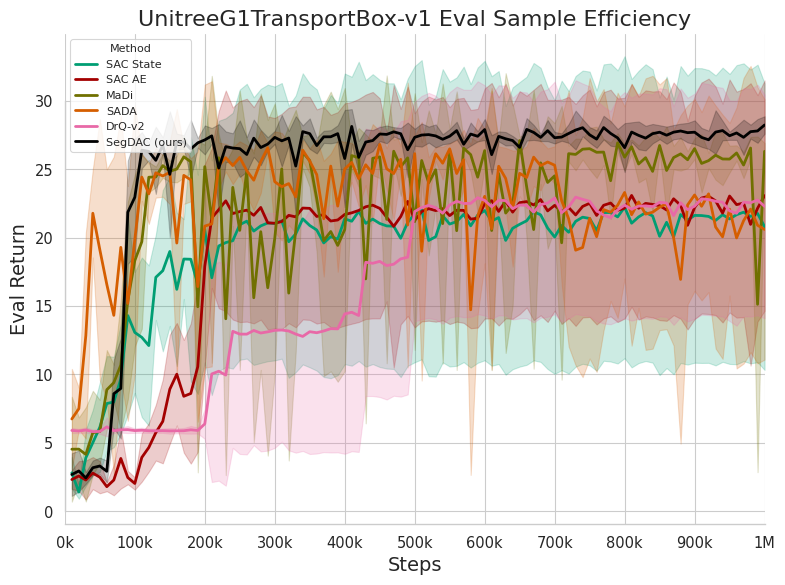

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import MultipleLocator, FuncFormatter

from comet_ml.query import Parameter, Tag
import comet_ml

PROJECT_NAME = "segdac"
WORKSPACE_NAME = "alexandrebrown"

comet_ml.login()

api = comet_ml.API()

EXPECTED_NB_SEEDS = 5


tasks = [
    "PushCube-v1",
    "PullCube-v1",
    "PickCube-v1",
    "PokeCube-v1",
    "PullCubeTool-v1",
    "LiftPegUpright-v1",
    "UnitreeG1PlaceAppleInBowl-v1",
    "UnitreeG1TransportBox-v1",
]

logged_task_names = {
    "PushCube-v1": ["PushCube-v1", "PushCubeFixed-v1"],
    "PullCube-v1": ["PullCube-v1"],
    "PickCube-v1": ["PickCube-v1", "PickCubeVisual-v1"],
    "PokeCube-v1": ["PokeCube-v1"],
    "PullCubeTool-v1": ["PullCubeTool-v1"],
    "LiftPegUpright-v1": ["LiftPegUpright-v1"],
    "UnitreeG1PlaceAppleInBowl-v1": ["UnitreeG1PlaceAppleInBowl-v1"],
    "UnitreeG1TransportBox-v1": ["UnitreeG1TransportBox-v1"],
}

color_map = {
    "sac_state": "#009E73",
    "sac_ae": "#A30000",
    "madi": "#707000",
    "sada": "#D55E00",
    "drqv2": "#e869a7",
    "segdac_sac_sam_enc_decoder_q_cond": "#000000",
    # "segdac_decoder_q_value_change_aux_critic": "#0008FF",
}

algo_name_mapping = {
    "sac_state": "SAC State",
    "sac_ae": "SAC AE",
    "madi": "MaDi",
    "sada": "SADA",
    "drqv2": "DrQ-v2",
    "segdac_sac_sam_enc_decoder_q_cond": "SegDAC (ours)",
    # "segdac_decoder_q_value_change_aux_critic": "SegDAC + Aux (ours)",
}

output_eval_results_folder = Path("results/eval")
output_plots_folder = output_eval_results_folder / Path("plots")
output_plots_folder.mkdir(parents=True, exist_ok=True)

sns.set_theme(context="paper", style="whitegrid", font_scale=1.2)


def xfmt(x, pos):
    if x >= 1_000_000:
        return f"{int(x/1_000_000)}M"
    else:
        return f"{int(x/1000)}k"


for task_name in tasks:
    output_data = {}
    task_experiments = []
    for logged_task_name in logged_task_names[task_name]:
        baselines_experiments = api.query(
            WORKSPACE_NAME,
            PROJECT_NAME,
            (Parameter("env|id") == logged_task_name) & Tag("baseline"),
        )
        segdac_experiments = api.query(
            WORKSPACE_NAME,
            PROJECT_NAME,
            (Parameter("env|id") == logged_task_name) & Tag("paper-result"),
        )
        # segdac_aux_experiments = api.query(
        #     WORKSPACE_NAME,
        #     PROJECT_NAME,
        #     (Parameter("env|id") == logged_task_name) & Tag("paper-result-aux"),
        # )

        task_experiments += (
            baselines_experiments + segdac_experiments #+ segdac_aux_experiments
        )

    nb_algos = len(algo_name_mapping.keys())
    expected_number_of_runs = EXPECTED_NB_SEEDS * nb_algos

    assert (
        len(task_experiments) == expected_number_of_runs
    ), f"Found {len(task_experiments)} experiments for task {task_name}, expected {expected_number_of_runs}!"

    algo_to_task_metrics = {}
    for algo_name in algo_name_mapping.keys():
        algo_experiments = []
        for experiment in task_experiments:
            if (
                algo_name.lower()
                in experiment.get_parameters_summary("algo|name")[
                    "valueCurrent"
                ].lower()
            ):
                algo_experiments.append(experiment)

        assert (
            len(algo_experiments) == EXPECTED_NB_SEEDS
        ), f"Found {len(algo_experiments)} experiments for {algo_name}, expected {EXPECTED_NB_SEEDS} for task {task_name}!"

        algo_task_seeds_returns = []
        algo_task_seeds_steps = []
        for algo_experiment in algo_experiments:
            unique_experiment_returns = {}
            experiment_returns = list(
                sorted(
                    algo_experiment.get_metrics("eval_return"), key=lambda x: x["step"]
                )
            )
            for exp_return in experiment_returns:
                step = int(exp_return["step"])
                if unique_experiment_returns.get(step, None) is None:
                    unique_experiment_returns[step] = float(exp_return["metricValue"])

            logged_steps = list(sorted(unique_experiment_returns.keys()))

            algo_task_seeds_returns.append(
                [unique_experiment_returns[s] for s in logged_steps]
            )
            algo_task_seeds_steps.append(logged_steps)

        # (nb_seeds, nb_metric_measurements) eg: (5, 100) 100 => 1M steps, evaluated every 10k steps = 100 measurements
        algo_task_seeds_returns = np.stack(algo_task_seeds_returns)

        algo_task_return_means = np.mean(
            algo_task_seeds_returns, axis=0
        )  # (nb_metric_measurements,)
        algo_task_return_stds = np.std(
            algo_task_seeds_returns, axis=0
        )  # (nb_metric_measurements,)

        output_data[algo_name] = {}
        for seed in range(algo_task_seeds_returns.shape[0]):
            output_data[algo_name][f"seed_{seed+1}"] = {
                "return": algo_task_seeds_returns[seed].tolist(),
                "step": algo_task_seeds_steps[seed],
            }
        output_data[algo_name]["aggregated"] = {
            "return_mean": algo_task_return_means.tolist(),
            "return_std": algo_task_return_stds.tolist(),
            "step": algo_task_seeds_steps[seed],
        }

        algo_to_task_metrics[algo_name] = {
            "return_mean": algo_task_return_means,
            "return_std": algo_task_return_stds,
        }

    fig, ax = plt.subplots(figsize=(8, 6))

    last_step = algo_task_seeds_steps[0][-1]

    nb_ticks = 10

    ax.xaxis.set_major_locator(MultipleLocator(last_step // nb_ticks))
    ax.xaxis.set_major_formatter(FuncFormatter(xfmt))

    step_interval = algo_task_seeds_steps[0][-1] - algo_task_seeds_steps[0][-2]

    x_ticks = np.arange(0, last_step + step_interval, step_interval)[1:]

    for algo_name in algo_name_mapping.keys():
        color = color_map[algo_name]

        return_means = algo_to_task_metrics[algo_name]["return_mean"]
        return_stds = algo_to_task_metrics[algo_name]["return_std"]

        assert len(return_means) == len(return_stds)
        # 1M steps, evaluated every 10k steps interval = 100 data points
        assert len(return_means) == last_step // step_interval

        ax.plot(
            x_ticks,
            return_means,
            label=algo_name_mapping[algo_name],
            color=color,
            linewidth=2,
        )
        lower = return_means - return_stds
        upper = return_means + return_stds
        ax.fill_between(x_ticks, lower, upper, color=color, alpha=0.2)

    ax.set_title(f"{task_name} Eval Sample Efficiency", fontsize=16)
    ax.set_xlabel("Steps", fontsize=14)
    ax.set_ylabel("Eval Return", fontsize=14)
    ax.set_xlim(0, last_step)
    ax.legend(
        title="Method", fontsize=8, title_fontsize=8, frameon=True, loc="upper left"
    )
    sns.despine(fig=fig, ax=ax, trim=True)
    fig.tight_layout()

    out_fname = output_plots_folder / Path(task_name.lower() + "_sample_efficiency.pdf")
    fig.savefig(out_fname)
    plt.show()

    with open(
        output_eval_results_folder / Path(task_name.lower() + "_eval_data.json"), "w"
    ) as f:
        json.dump(output_data, f)